### Import Libraries & Global Constants

In [37]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error
# Seed for reproducibility
SEED = 42

### Load Data

In [38]:
# Load the data from the CSV file
#listings = pd.read_csv('../data/listings.csv')
listings = pd.read_excel('listings (3) 2.xls', header=0)


In [39]:
print(listings["neighbourhood_cleansed"].nunique())


17


# Exploratory Data Analysis

In [40]:
# Block for testing stuff

listings["room_type"].unique()

# Count the values of each of the room types
listings["room_type"].value_counts()


,count
room_type,
Entire home/apt,8747
Private room,1305
Shared room,46
Hotel room,1


## Data cleaning



In [41]:


def remove_columns(df, columns_to_remove):
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    return df.drop(columns=existing_columns)

def clean_price(df):
    # First check that price is not already a numeric value
    if df['price'].dtype == np.float64:
        return df
    df_copy = df.copy()
    # Remove the commas and dollar signs from the price column
    df_copy['price'] = df_copy['price'].str.replace("$", "").str.replace(",", "").astype(float)
    return df_copy


def fill_missing_values(df):
    df_copy = df.copy()
    #If type is numeric, fill with mean
    for col in df_copy.select_dtypes(include='number').columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    # Otherwise, if type is anything else, delete row
    df_copy = df_copy.dropna()

    return df_copy

def convert_boolean_columns(df):
    # Convert boolean columns to 0 and 1
    boolean_columns = df.select_dtypes(include='bool').columns
    df_copy = df.copy()
    for col in boolean_columns:
        df_copy[col] = df_copy[col].astype(int)

    # Needed since boolean data is inconsistent
    for col in df.columns:
        if set(df[col].unique()) == {'f', 't'}:
            df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
    return df_copy


def one_hot_encode_room_type(df):
    # One hot encode the room_type column
    # First check that the room_type column exists
    if 'room_type' not in df.columns:
        return df
    df_copy = pd.get_dummies(df, columns=['room_type'])
    return df_copy

def label_encode_room_type(df):
    df_copy = df.copy()
    if 'room_type' in df_copy.columns:
        le = LabelEncoder()
        df_copy['room_type'] = le.fit_transform(df_copy['room_type'])
    return df_copy


In [42]:
columns_to_remove = [ 'id', 'listing_url', 'scrape_id', 'last_scraped',
                     'source', 'name', 'description', 'neighborhood_overview',
                     'picture_url', 'host_id', 'host_url', 'host_name', 'host_location',
                     'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                     'host_total_listings_count', 'host_verifications', 'neighbourhood',
                     'neighbourhood_group_cleansed', 'property_type', 'bathrooms_text', 'amenities',
                     'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                     'calendar_updated', 'calendar_last_scraped', 'number_of_reviews_l30d', 'first_review', 'last_review', 'host_since',
                     'license',  'calculated_host_listings_count_entire_homes',
                     'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms' ]

# Clean the data using One-Hot Encoding
listings_clean_one_hot = remove_columns(listings, columns_to_remove)
listings_clean_one_hot = fill_missing_values(listings_clean_one_hot)
listings_clean_one_hot = clean_price(listings_clean_one_hot)
listings_clean_one_hot = one_hot_encode_room_type(listings_clean_one_hot)
listings_clean_one_hot = convert_boolean_columns(listings_clean_one_hot)

# Clean the data using Label Encoding
listings_clean_label = remove_columns(listings, columns_to_remove)
listings_clean_label = fill_missing_values(listings_clean_label)
listings_clean_label = clean_price(listings_clean_label)
listings_clean_label = label_encode_room_type(listings_clean_label)
listings_clean_label = convert_boolean_columns(listings_clean_label)


# Assert all values are numeric
assert listings_clean_one_hot.dtypes.all() != np.dtype('O'), 'Not all values are numeric'
assert listings_clean_label.dtypes.all() != np.dtype('O'), 'Not all values are numeric'


<ipython-input-41-7b764846990c>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
<ipython-input-41-7b764846990c>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})


In [43]:
print("One-Hot Encoded Data:")
print(listings_clean_one_hot.head(10))
print("Label Encoded Data:")
print(listings_clean_label.head(10))

One-Hot Encoded Data:
    host_response_time  host_response_rate  host_acceptance_rate  \
0       within an hour                 1.0                  1.00   
1   within a few hours                 1.0                  0.67   
2       within an hour                 1.0                  0.96   
3       within an hour                 1.0                  0.96   
4       within an hour                 1.0                  0.67   
6       within an hour                 1.0                  1.00   
7   within a few hours                 1.0                  0.78   
8       within an hour                 1.0                  0.67   
10  within a few hours                 1.0                  0.94   
12  within a few hours                 1.0                  0.71   

    host_is_superhost  host_listings_count  host_has_profile_pic  \
0                   1                    2                     1   
1                   0                    1                     1   
2                   1    

In [44]:
print("Rows before cleaning:", len(listings))
print("Number of columns before cleaning:", len(listings.columns))
print("Rows after cleaning (One-Hot):", len(listings_clean_one_hot))
print("Number of columns after cleaning (One-Hot):", len(listings_clean_one_hot.columns))
print("Rows after cleaning (Label):", len(listings_clean_label))
print("Number of columns after cleaning (Label):", len(listings_clean_label.columns))


Rows before cleaning: 10099
Number of columns before cleaning: 75
Rows after cleaning (One-Hot): 7019
Number of columns after cleaning (One-Hot): 37
Rows after cleaning (Label): 7019
Number of columns after cleaning (Label): 35


In [45]:
print("Data types in listings_clean_one_hot:")
print(listings_clean_one_hot.dtypes)


Data types in listings_clean_one_hot:
host_response_time                 object
host_response_rate                float64
host_acceptance_rate              float64
host_is_superhost                   int64
host_listings_count                 int64
host_has_profile_pic                int64
host_identity_verified              int64
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                   object
availability_30                     int64
availability_60                     int64
availability_90                     int64
availability_365                    int64
number_of_reviews                   in

In [46]:
# Display a few rows of the non-numeric columns
non_numeric_cols = listings_clean_one_hot.select_dtypes(include=['object']).columns
print(listings_clean_one_hot[non_numeric_cols].head())


   host_response_time neighbourhood_cleansed has_availability
0      within an hour                Frogner                t
1  within a few hours             Gamle Oslo                t
2      within an hour             Gamle Oslo                t
3      within an hour             Gamle Oslo                t
4      within an hour         St. Hanshaugen                t


<ipython-input-41-7b764846990c>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
<ipython-input-47-575107221e1b>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['has_availability'] = df_copy['has_availability'].replace({'t': 1, 'f': 0})


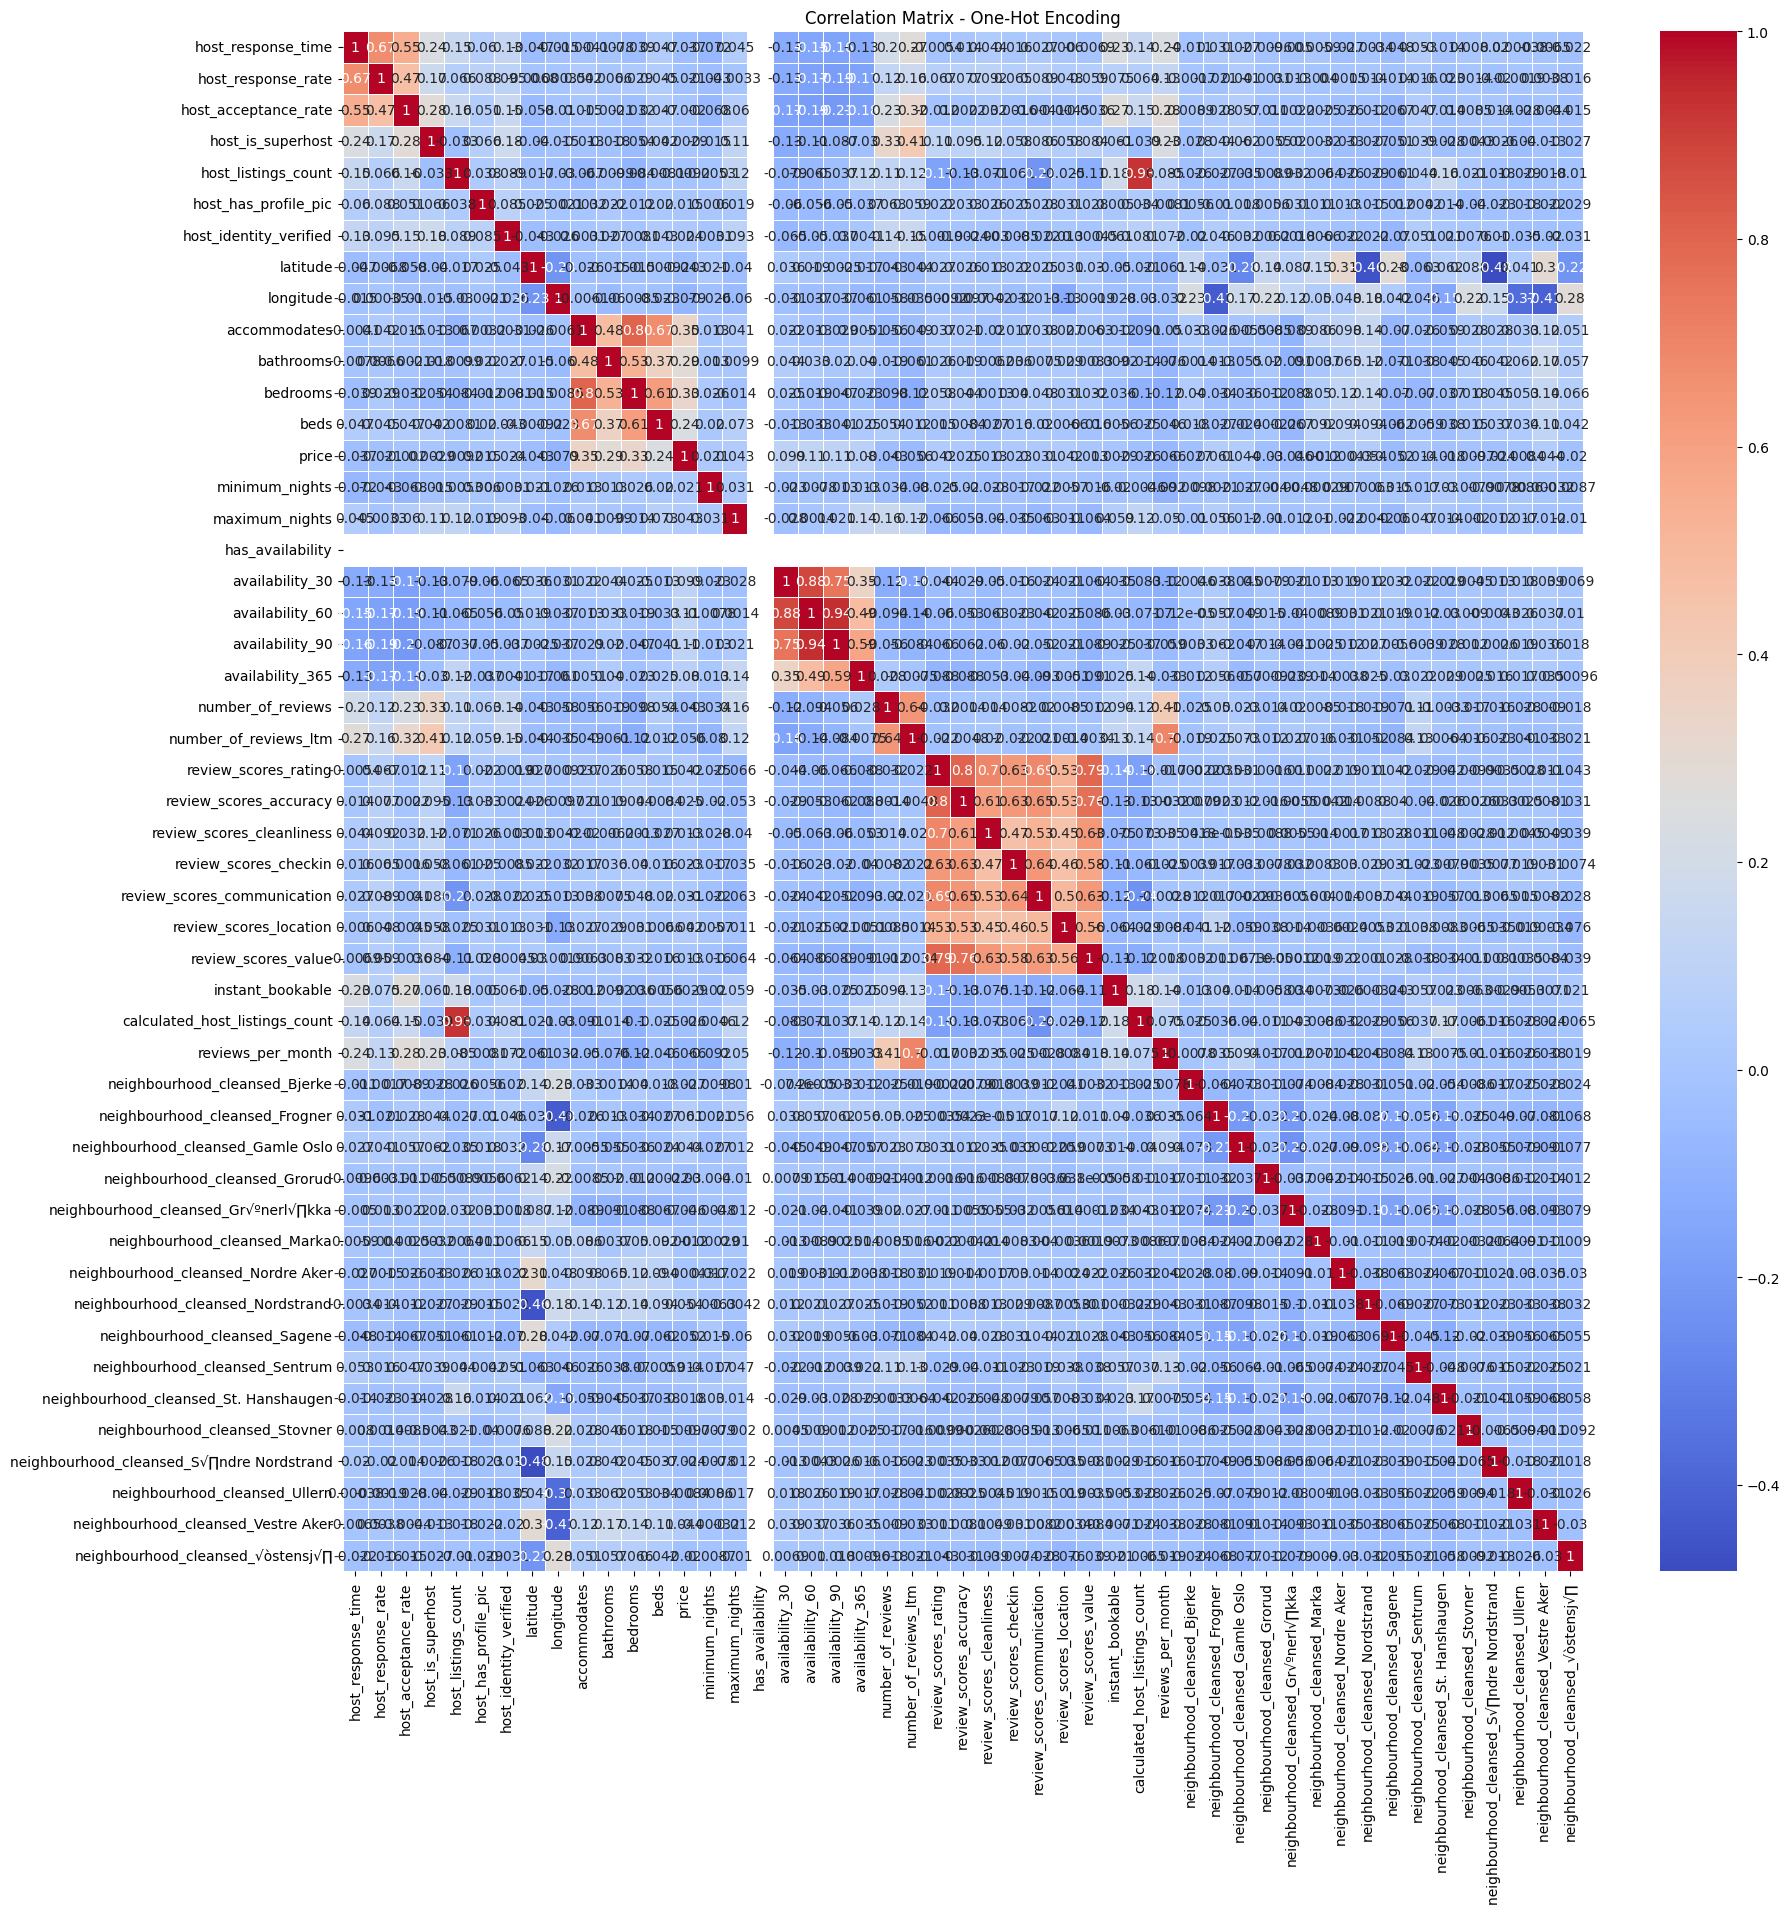

In [47]:
from sklearn.preprocessing import LabelEncoder  # Ensure this is imported if not already

def convert_categorical_columns(df):
    df_copy = df.copy()

    # Convert 'has_availability' from 't'/'f' to 1/0
    df_copy['has_availability'] = df_copy['has_availability'].replace({'t': 1, 'f': 0})

    # Label encode 'host_response_time'
    if 'host_response_time' in df_copy.columns:
        le = LabelEncoder()
        df_copy['host_response_time'] = le.fit_transform(df_copy['host_response_time'])

    # Drop 'neighbourhood_cleansed' and one-hot encode it
    if 'neighbourhood_cleansed' in df_copy.columns:
        df_copy = pd.get_dummies(df_copy, columns=['neighbourhood_cleansed'], drop_first=True)

    return df_copy

# Update the cleaning process
listings_clean_one_hot = remove_columns(listings, columns_to_remove)
listings_clean_one_hot = fill_missing_values(listings_clean_one_hot)
listings_clean_one_hot = clean_price(listings_clean_one_hot)
listings_clean_one_hot = convert_boolean_columns(listings_clean_one_hot)
listings_clean_one_hot = convert_categorical_columns(listings_clean_one_hot)

# After converting and cleaning, drop any remaining non-numeric columns
listings_clean_one_hot = listings_clean_one_hot.select_dtypes(exclude=['object'])

# Now plot the correlation matrix
corr_one_hot = listings_clean_one_hot.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_one_hot, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix - One-Hot Encoding")
plt.show()



In [48]:
print("Data types in listings_clean_label:")
print(listings_clean_label.dtypes)
# Display a few rows of the non-numeric columns
non_numeric_cols_label = listings_clean_label.select_dtypes(include=['object']).columns
print(listings_clean_label[non_numeric_cols_label].head())


Data types in listings_clean_label:
host_response_time                 object
host_response_rate                float64
host_acceptance_rate              float64
host_is_superhost                   int64
host_listings_count                 int64
host_has_profile_pic                int64
host_identity_verified              int64
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
room_type                           int64
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                   object
availability_30                     int64
availability_60                     int64
availability_90                     int64
availability_365                    int6

<ipython-input-41-7b764846990c>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
<ipython-input-49-e4dc8508d73b>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['has_availability'] = df_copy['has_availability'].replace({'t': 1, 'f': 0})


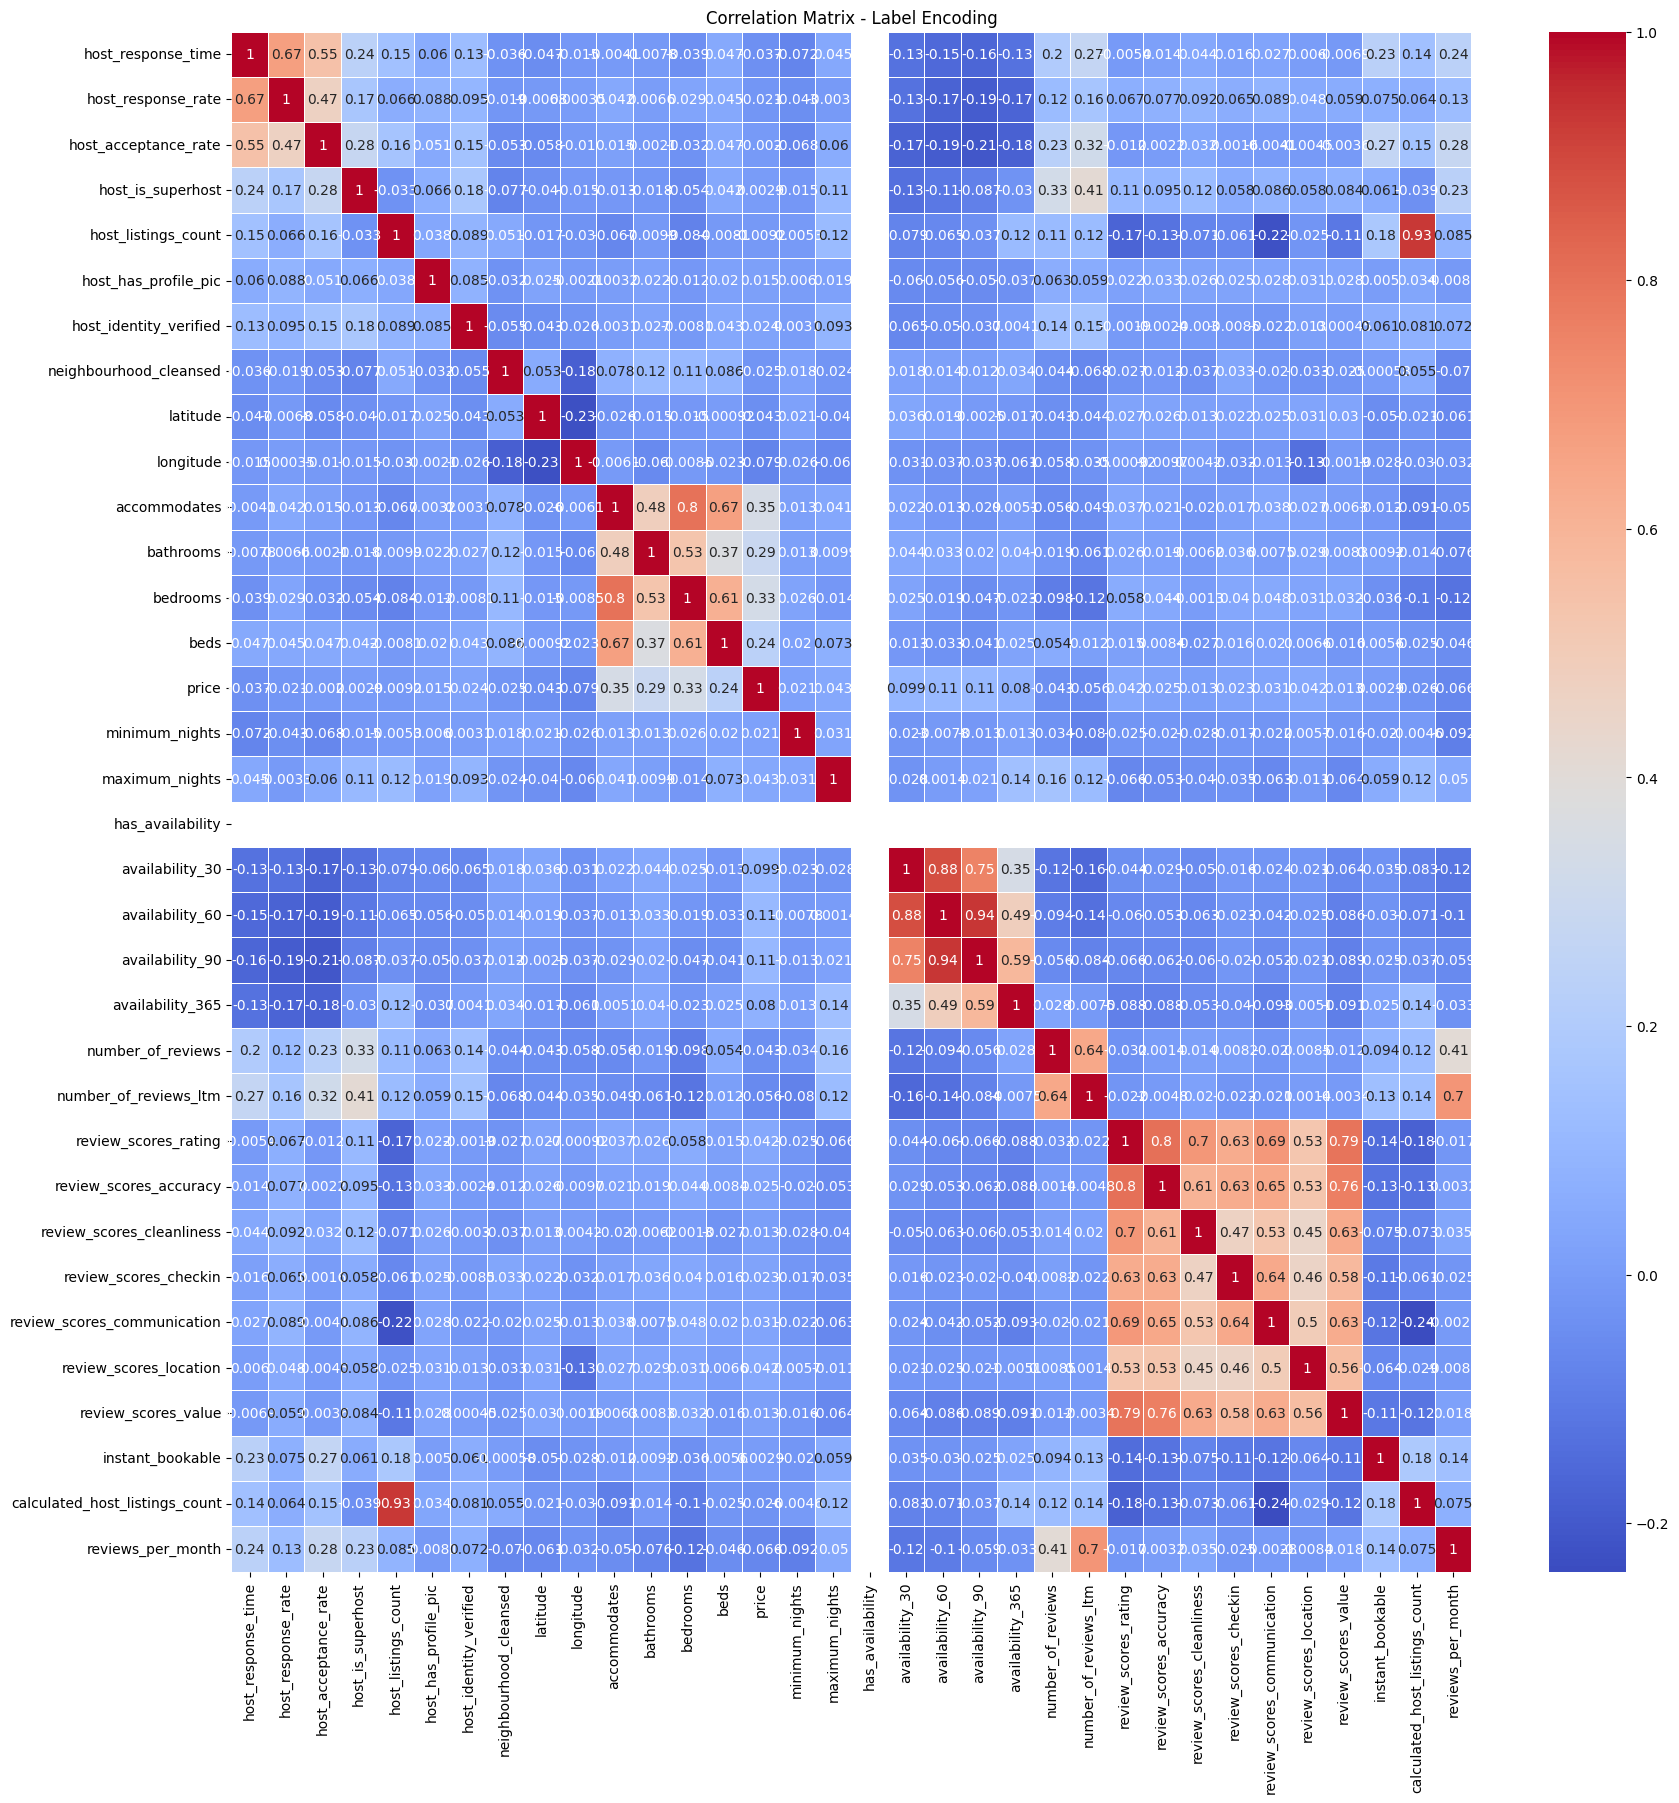

In [49]:
from sklearn.preprocessing import LabelEncoder  # Ensure this is imported if not already

def convert_categorical_columns_label(df):
    df_copy = df.copy()

    # Convert 'has_availability' from 't'/'f' to 1/0
    if 'has_availability' in df_copy.columns:
        df_copy['has_availability'] = df_copy['has_availability'].replace({'t': 1, 'f': 0})

    # Label encode 'host_response_time'
    if 'host_response_time' in df_copy.columns:
        le_response_time = LabelEncoder()
        df_copy['host_response_time'] = le_response_time.fit_transform(df_copy['host_response_time'])

    # Label encode 'neighbourhood_cleansed'
    if 'neighbourhood_cleansed' in df_copy.columns:
        le_neighbourhood = LabelEncoder()
        df_copy['neighbourhood_cleansed'] = le_neighbourhood.fit_transform(df_copy['neighbourhood_cleansed'])

    return df_copy

# Update the cleaning process for label encoding
listings_clean_label = remove_columns(listings, columns_to_remove)
listings_clean_label = fill_missing_values(listings_clean_label)
listings_clean_label = clean_price(listings_clean_label)
listings_clean_label = convert_boolean_columns(listings_clean_label)  # Convert boolean columns
listings_clean_label = convert_categorical_columns_label(listings_clean_label)  # New function

# After converting and cleaning, drop any remaining non-numeric columns
listings_clean_label = listings_clean_label.select_dtypes(exclude=['object', 'datetime64[ns]'])

# Now plot the correlation matrix
corr_label = listings_clean_label.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_label, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix - Label Encoding")
plt.show()


This means removing
- host_total_listings_count


# Quick modelling

In [50]:
# Split the data into features and target for One-Hot Encoded Data
X_one_hot = listings_clean_one_hot.drop(columns='price')
y_one_hot = listings_clean_one_hot['price']

# Split the data into training and testing sets for One-Hot Encoded Data
X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(X_one_hot, y_one_hot, test_size=0.2, random_state=SEED)


In [51]:

# Initialize and fit the model for One-Hot Encoded Data
model_one_hot = LinearRegression()
model_one_hot.fit(X_train_one_hot, y_train_one_hot)

# Evaluate One-Hot Encoded Model
print("One-Hot Encoding:")
print("R^2:", model_one_hot.score(X_test_one_hot, y_test_one_hot))

# Split the data into features and target for Label Encoded Data
X_label = listings_clean_label.drop(columns='price')
y_label = listings_clean_label['price']

# Split the data into training and testing sets for Label Encoded Data
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=SEED)

# Initialize and fit the model for Label Encoded Data
model_label = LinearRegression()
model_label.fit(X_train_label, y_train_label)

# Evaluate Label Encoded Model
print("Label Encoding:")
print("R^2:", model_label.score(X_test_label, y_test_label))

One-Hot Encoding:
R^2: 0.21338302967868583
Label Encoding:
R^2: 0.20718872161933355
